In [1]:
from datetime import date, timedelta, datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as plt
import Price_Models as pm
import Data

n = 100 #Sample size
iterations = 80 # max tries

# Set to true to update database from online data, if false will pull data from csv files
Update = False 
trade_days = 256
est_price_path = './Data/tmp.csv'

#-- Desired interval examined --
start_date = date(2018,11,7)
end_date = date(2023,11,24)
df_end = end_date + timedelta(days=1) #Add one day as yf functions don't include last day

# Importing data
df = Data.GetData(start_date, df_end, trade_days, Update)
df = df[pd.to_datetime(df.lastTradeDate).dt.date > date(2023,11,21)]
df = df[df.lastPrice > 10]
df = df.sample(n)  #Reduce data size for testing purposes
r = 0.0553
# Uncomment to select only one stock
# stock = '^SPX'
# df = df[df['symbol'] == stock]

def compute_errors(r, dsigma):
    LSMC_est_price = [] 
    BIN_est_price = [] 
    BS_est_price = [] 
    MJD_est_price = []

    for i in range(len(df)):
        S0 = df.iloc[i].S0       # Sets S0
        K = df.iloc[i].strike
        T = df.iloc[i].maturity / 365
        sigma = df.iloc[i].sigma + dsigma
        type = df.iloc[i].optionType

        if df.iloc[i].method == 'A':
            computed_price_LSMC = pm.LSMC(S0, K, T, sigma, r, type)
            computed_price_BIN = pm.BinomialTree(S0, K, T, sigma, r, type)
            computed_price_BS = np.nan
            computed_price_MJD = np.nan
        elif df.iloc[i].method == 'E':
            computed_price_LSMC = np.nan
            computed_price_BIN = np.nan     
            computed_price_BS = pm.BS(S0, K, T, sigma, r, type)
            computed_price_MJD = pm.MJD(S0, K, T, sigma, r, type)
        else:
            raise Exception('Unexpected option method')

        LSMC_est_price.append(computed_price_LSMC)
        BIN_est_price.append(computed_price_BIN)
        BS_est_price.append(computed_price_BS)
        MJD_est_price.append(computed_price_MJD)

    LSMC_perc_error = (df.lastPrice - LSMC_est_price)/df.lastPrice
    BIN_perc_error = (df.lastPrice - BIN_est_price)/df.lastPrice
    BS_perc_error = (df.lastPrice - BS_est_price)/df.lastPrice
    MJD_perc_error = (df.lastPrice - MJD_est_price)/df.lastPrice

    averageLSMC = np.sqrt(np.mean((LSMC_perc_error)**2))
    averageBIN = np.sqrt(np.mean((BIN_perc_error)**2))
    averageBS = np.sqrt(np.mean((BS_perc_error)**2))
    averageMJD = np.sqrt(np.mean((MJD_perc_error)**2))

    return averageLSMC, averageBIN, averageBS, averageMJD

df

,Unnamed: 0,symbol,optionType,expiration,strike,lastPrice,lastTradeDate,inTheMoney,maturity,S0,sigma,returns,method
10377,10377,MSFT,calls,2025-12-19,460.0,36.25,2023-11-22,False,758,377.850006,0.312164,0.256756,A
33933,33933,^SPX,calls,2024-02-29,4630.0,102.70,2023-11-22,False,99,4556.620117,0.218748,0.097296,E
34762,34762,^SPX,puts,2024-08-16,4450.0,139.88,2023-11-22,False,268,4556.620117,0.218748,0.097296,E
33630,33630,^SPX,calls,2024-01-31,4710.0,38.90,2023-11-22,False,70,4556.620117,0.218748,0.097296,E
30271,30271,^SPX,calls,2023-11-24,4430.0,129.04,2023-11-22,True,2,4556.620117,0.218748,0.097296,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31704,31704,^SPX,calls,2023-12-08,4280.0,287.17,2023-11-22,True,16,4556.620117,0.218748,0.097296,E
34284,34284,^SPX,calls,2024-04-19,4875.0,48.60,2023-11-22,False,149,4556.620117,0.218748,0.097296,E
727,727,AAPL,calls,2025-12-19,60.0,135.95,2023-11-22,True,758,191.309998,0.331333,0.269954,A
6528,6528,META,puts,2024-04-19,335.0,22.13,2023-11-22,False,149,341.489990,0.449842,0.163992,A


In [2]:
x1 = np.linspace(0.03,0.3, iterations) # Values to test r
x2 = np.linspace(-0.4,0, iterations) # Values to test dsigma

def testvalues():
    r_s = 0.15
    dsigma_s = -0.1
    r, dsigma = r_s, dsigma_s
    errors = compute_errors(r, dsigma)
    df_errors_r= pd.DataFrame({'r': r, 'dsigma': dsigma, 'LSMCerror' : errors[0], 'BINerror' : errors[1], 
                                   'BSerror' : errors[2], 'MJDerror' : errors[3]},index=[0])

    # testing r values
    for i in tqdm(range(iterations)):
        # lamb += 0.1*(np.random.rand() - 0.5)
        r = x1[i]
        errors = compute_errors(r, dsigma)
        df_errors_r.loc[i+1] = [r,dsigma,*errors]

    df_errors_dsigma = pd.DataFrame({'r': r, 'dsigma': dsigma, 'LSMCerror' : errors[0], 'BINerror' : errors[1], 
                                   'BSerror' : errors[2], 'MJDerror' : errors[3]},index=[0])
    r, dsigma = r_s, dsigma_s
    # testing dsigma values
    for i in tqdm(range(iterations)):
        #a += 0.2*(np.random.rand() - 0.5)
        dsigma = x2[i]
        errors = compute_errors(r, dsigma)
        df_errors_dsigma.loc[i+1] = [r,dsigma,*errors]

    return df_errors_r, df_errors_dsigma

values = testvalues()

100%|██████████| 80/80 [03:49<00:00,  2.87s/it]


In [3]:

values_r = pd.DataFrame(values[0]) 
values_dsigma = pd.DataFrame(values[1])

values_r.to_csv('./Data/calibration_r.csv')
values_dsigma.to_csv('./Data/calibration_dsigma.csv')

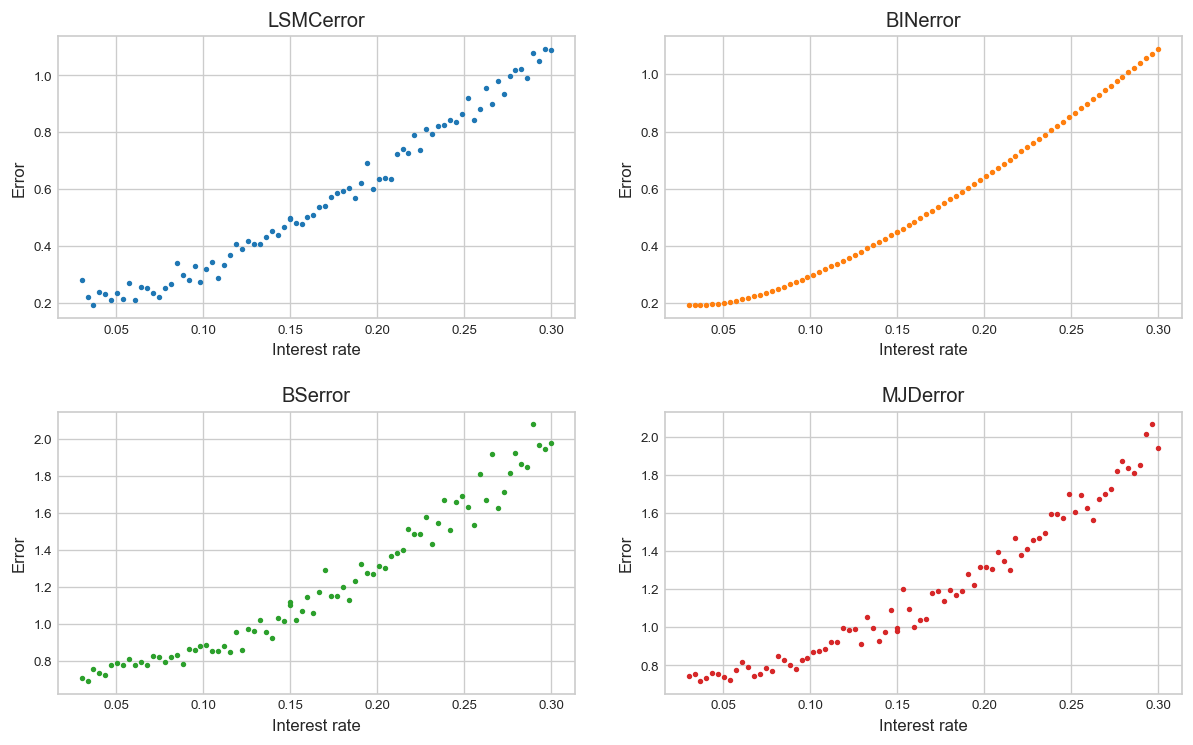

In [30]:
import scipy
import seaborn as sns
palette = sns.color_palette("tab20", 20)

%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid") 
fig, axes = plt.pyplot.subplots(nrows=2, ncols=2, figsize=(10,6), dpi = 120)
fig.tight_layout(h_pad=4, w_pad=3)
tmp_r = values_r.drop(columns=['r', 'dsigma'])
for i, ax in enumerate(axes.flatten()):
    data = tmp_r[tmp_r.columns[i]]
    ax.scatter(values_r.r, data, s = 5, color = palette[2*i])
    # Decorations
    ax.set_title(tmp_r.columns[i])
    ax.set_ylabel('Error')
    ax.set_xlabel('Interest rate')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.tick_params(labelsize=8)
plt.pyplot.savefig('./Presentation files/err_interest.png', dpi = 300,bbox_inches='tight')


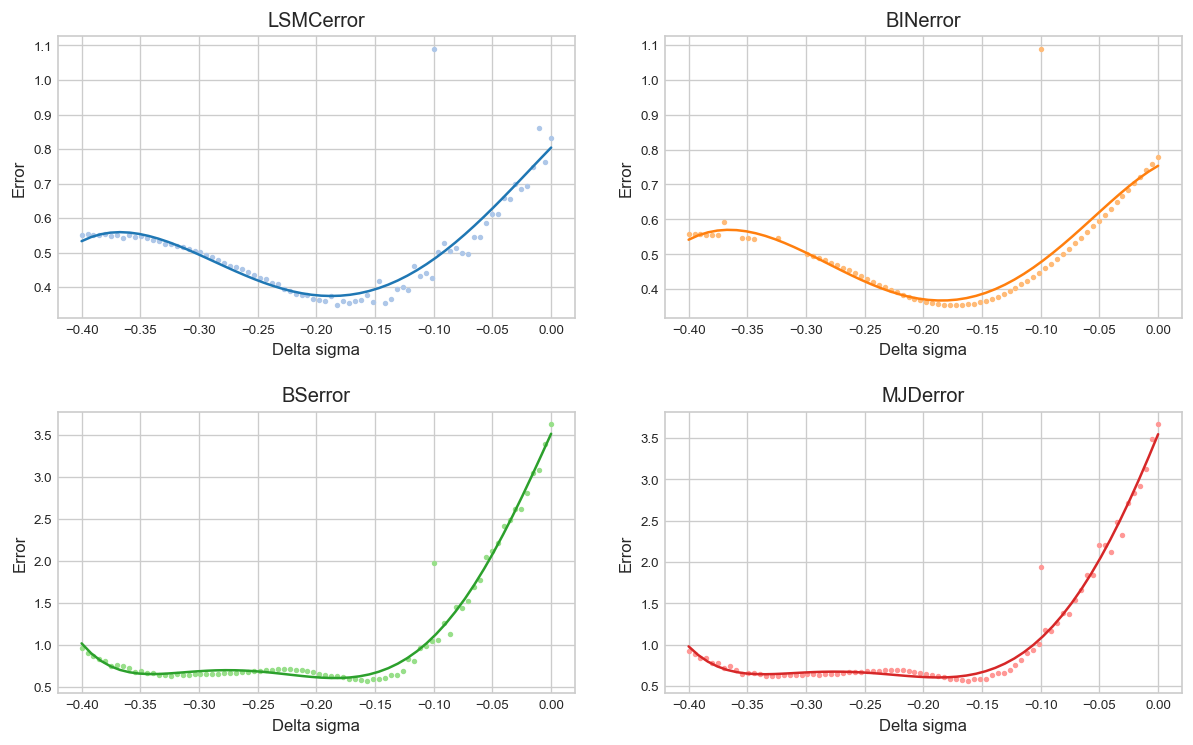

In [32]:
fig, axes = plt.pyplot.subplots(nrows=2, ncols=2, figsize=(10,6), dpi = 120)
fig.tight_layout(h_pad=4, w_pad=3)
tmp_sigma = values_dsigma.drop(columns=['r', 'dsigma'])

curveplot = lambda t,a,b,c,d,e,f: f*t**5+e*t**4+d*t**3+a*t**2+b*t+c
x = np.linspace(min(values_dsigma.dsigma), max(values_dsigma.dsigma))

for i, ax in enumerate(axes.flatten()):
    errors = tmp_sigma[tmp_sigma.columns[i]]
    #condition = np.isfinite(errors)
    condition = errors<1000
    model = scipy.optimize.curve_fit(curveplot, values_dsigma.dsigma[condition],  errors[condition])

    ax.scatter(values_dsigma.dsigma[condition], errors[condition], s = 5, color = palette[2*i+1])
    ax.plot(x, curveplot(x, *model[0]),color = palette[2*i])
    # Decorations
    ax.set_title(tmp_sigma.columns[i])
    ax.set_ylabel('Error')
    ax.set_xlabel('Delta sigma')
    # ax.xaxis.set_ticks_position('none')
    # ax.yaxis.set_ticks_position('none')
    ax.tick_params(labelsize=8)
plt.pyplot.savefig('./Presentation files/err_volatility.png', dpi = 300,bbox_inches='tight')
plt.pyplot.show()